# Data Analysis
* Created on Wed Jan, 27 2021 by Shangying Wang
* Last Modified: June 4, 2021
* This code is used for prediction the affinity (1 represents higher affinity and 0 represents lower affinity) of the spike protein

In [1]:
#import necessary modules
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import csv
import os
import matplotlib.pyplot as plt
import imageio
%matplotlib inline
import seaborn as sns
sns.set(style="ticks", color_codes=True)
#import pdb
from platform import python_version
print(python_version())

3.7.8


In [2]:
from keras.optimizers import SGD, Adam
from keras import layers
from keras.layers import Input, Dense, Dropout, Flatten, Average, BatchNormalization
#from tensorflow.keras.layers import Conv1D,MaxPool1D
from keras.layers.convolutional import Convolution1D, MaxPooling1D
from keras.initializers import RandomNormal
from keras import models
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler,StandardScaler,RobustScaler

from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.utils import shuffle
from glob import glob
print(tf.__version__)

2.4.1


## Load figures

In [3]:
end=480 #480 means to use the first 500 pics and the end time is 10ns; ...7980 means to use the first 8000 pics and the end time is 160ns.
data_N501Y = sorted(glob(os.path.join("pic_N501Y_subtract_ave","*.png")))[0:end]  #higher affinity (for training)
data_Q498Y = sorted(glob(os.path.join("pic_Q498Y_subtract_ave","*.png")))[0:end]  #higher affinity
data_N501V = sorted(glob(os.path.join("pic_N501V_subtract_ave","*.png")))[0:end] #higher affinity (for training)
data_Q493Y = sorted(glob(os.path.join("pic_Q493Y_subtract_ave","*.png")))[0:end]  #higher affinity
data_N501T = sorted(glob(os.path.join("pic_N501T_subtract_ave","*.png")))[0:end] #higher affinity (for training)
data_E484K = sorted(glob(os.path.join("pic_E484K_subtract_ave","*.png")))[0:end] #higher affinity 

data_N501S = sorted(glob(os.path.join("pic_N501S_subtract_ave","*.png")))[0:end]  #lower affinity (for training)
data_Q493N = sorted(glob(os.path.join("pic_Q493N_subtract_ave","*.png")))[0:end]  #lower affinity 
data_Q498N = sorted(glob(os.path.join("pic_Q498N_subtract_ave","*.png")))[0:end]  #lower affinity (for training)
data_Q498K = sorted(glob(os.path.join("pic_Q498K_subtract_ave","*.png")))[0:end]  #lower affinity
data_N501D = sorted(glob(os.path.join("pic_N501D_subtract_ave","*.png")))[0:end] #lower affinity (for training)
data_G502P = sorted(glob(os.path.join("pic_G502P_subtract_ave","*.png")))[0:end] #lower affinity

#data_WT = glob(os.path.join("pic_WT_0-114ns_subtract_ave","*.png")) #references
# 1
#training_data = np.array(data_N501Y+data_Q498Y+data_N501T+data_E484K+data_N501S+data_Q493N+data_N501D+data_G502P)
# 2
#training_data = np.array(data_N501Y+data_Q498Y+data_N501D+data_G502P)
# 3
# training_data = np.array(data_N501Y+data_G502P)
# 4
training_data = np.array(data_N501Y+data_N501V+data_N501T+data_N501S+data_Q498N+data_N501D)
test_dataA = np.array(data_Q498Y+data_G502P)
test_dataB = np.array(data_Q493Y+data_Q498K)
test_dataC = np.array(data_E484K+data_Q493N)
train_size1 = len(data_N501Y+data_N501V+data_N501T) #size of train data with high affinity
train_size2 = len(data_N501S+data_Q498N+data_N501D)#size of train data with low affinity
test_size1A = len(data_Q498Y)#size of test data with high affinity
test_size2A = len(data_G502P)#size of test data with low affinity
test_size1B = len(data_Q493Y)#size of test data with high affinity
test_size2B = len(data_Q498K)#size of test data with low affinity
test_size1C = len(data_E484K)#size of test data with high affinity
test_size2C = len(data_Q493N)#size of test data with low affinity

In [4]:
fdata_train = [imageio.imread(img_name) for img_name in training_data]
fdata_train = np.array(fdata_train).astype(np.float32)[:,:,:,None] / 255   #normalize the input to be within -1 to 1
fdata_test = [imageio.imread(img_name) for img_name in test_dataA]
fdata_testA = np.array(fdata_test).astype(np.float32)[:,:,:,None] / 255   #normalize the input to be within -1 to 1
fdata_test = [imageio.imread(img_name) for img_name in test_dataB]
fdata_testB = np.array(fdata_test).astype(np.float32)[:,:,:,None] / 255   #normalize the input to be within -1 to 1
fdata_test = [imageio.imread(img_name) for img_name in test_dataC]
fdata_testC = np.array(fdata_test).astype(np.float32)[:,:,:,None] / 255   #normalize the input to be within -1 to 1
np.shape(fdata_train)

(2880, 62, 55, 1)

In [5]:
train_y = np.hstack((np.ones((train_size1,),dtype=int),np.zeros((train_size2,), dtype=int)))
test_yA = np.hstack((np.ones((test_size1A,),dtype=int),np.zeros((test_size2A,), dtype=int)))
test_yB = np.hstack((np.ones((test_size1B,),dtype=int),np.zeros((test_size2B,), dtype=int)))
test_yC = np.hstack((np.ones((test_size1C,),dtype=int),np.zeros((test_size2C,), dtype=int)))
np.shape(train_y)

(2880,)

In [6]:
indices_train = tf.random.shuffle(tf.range(train_size1+train_size2))
#indices_test = tf.random.shuffle(tf.range(test_size1+test_size2))
train_images, test_images, train_labels, test_labels = train_test_split(fdata_train[indices_train], train_y[indices_train], test_size=0.1, random_state=123)
test2A_images = fdata_testA
test2A_labels = test_yA
test2B_images = fdata_testB
test2B_labels = test_yB
test2C_images = fdata_testC
test2C_labels = test_yC

In [7]:
class_names = ['Low Affinity','High Affinity']
# plt.figure(figsize=(11,13))
# for i in range(25):
#     plt.subplot(5,5,i+1)
#     plt.xticks([])
#     plt.yticks([])
#     plt.grid(False)
#     plt.imshow(train_images[i,:,:,0],cmap='gray')#plt.cm.binary
#     # The CIFAR labels happen to be arrays, 
#     # which is why you need the extra index
#     plt.xlabel(class_names[train_labels[i]])
# plt.show()

In [8]:
#model description
model = models.Sequential()
initializer = RandomNormal(mean=0.0, stddev=0.05, seed=None)
model.add(layers.Conv2D(8, (3, 3), kernel_initializer=initializer, activation='relu', input_shape=(62, 55, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(16, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
#model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(Dropout(0.5))
model.add(layers.Dense(5, activation='relu'))
model.add(layers.Dense(2,activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 60, 53, 8)         80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 26, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 24, 16)        1168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 12, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 2688)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2688)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 1

In [9]:
#compile model
model.compile(optimizer=Adam(lr=0.0001), #Adam optimizer
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# custom_early_stopping = EarlyStopping(
#     monitor='loss', 
#     patience=8, 
#     min_delta=1e-10, 
#     mode='min')
# history = model.fit(train_images, train_labels, epochs=20, 
#                     validation_data=(test_images, test_labels), callbacks=[custom_early_stopping])
history = model.fit(train_images, train_labels, epochs=60)

Epoch 1/60
81/81 [==============================] - 1s 9ms/step - loss: 0.6921 - accuracy: 0.5297
Epoch 2/60
81/81 [==============================] - 1s 8ms/step - loss: 0.6798 - accuracy: 0.6029
Epoch 3/60
81/81 [==============================] - 1s 8ms/step - loss: 0.6438 - accuracy: 0.7556
Epoch 4/60
81/81 [==============================] - 1s 8ms/step - loss: 0.5736 - accuracy: 0.8218
Epoch 5/60
81/81 [==============================] - 1s 8ms/step - loss: 0.4841 - accuracy: 0.8536
Epoch 6/60
81/81 [==============================] - 1s 8ms/step - loss: 0.3788 - accuracy: 0.8919
Epoch 7/60
81/81 [==============================] - 1s 8ms/step - loss: 0.2912 - accuracy: 0.9207
Epoch 8/60
81/81 [==============================] - 1s 8ms/step - loss: 0.2333 - accuracy: 0.9460
Epoch 9/60
81/81 [==============================] - 1s 8ms/step - loss: 0.1944 - accuracy: 0.9434
Epoch 10/60
81/81 [==============================] - 1s 8ms/step - loss: 0.1639 - accuracy: 0.9512
Epoch 11/60
81/81 [

In [10]:
# plt.plot(history.history['accuracy'], label='accuracy')
# #plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.ylim([0.7, 1.01])
# plt.legend(loc='lower right')

In [11]:
#model evaluation
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
test2A_loss, test2A_acc = model.evaluate(test2A_images,  test2A_labels, verbose=2)
test2B_loss, test2B_acc = model.evaluate(test2B_images,  test2B_labels, verbose=2)
test2C_loss, test2C_acc = model.evaluate(test2C_images,  test2C_labels, verbose=2)

9/9 - 0s - loss: 0.0011 - accuracy: 1.0000
30/30 - 0s - loss: 1.4483 - accuracy: 0.6792
30/30 - 0s - loss: 1.3830 - accuracy: 0.5323
30/30 - 0s - loss: 0.4512 - accuracy: 0.8656


In [12]:
#save model
model.save('save_CNN/spike_protein_02242021_12mutations_N501Y_N501V_N501T_N501S_Q498N_N501D_500_8_16_1.h5')
## Recreate the exact same model purely from the file:
#model = keras.models.load_model('save_CNN/spike_protein_02242021_12mutations_N501Y_N501V_N501T_N501S_Q498N_N501D_2000_8_16_1.h5')
#model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 60, 53, 8)         80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 26, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 24, 16)        1168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 12, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 2688)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2688)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 1

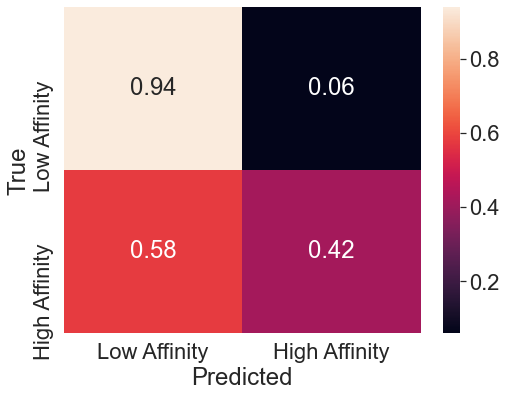

In [13]:
#plot the confusion matrix to visualize the classification results for data_Q498Y(H) and data_G502P (L)
predictions = model.predict(test2A_images)
y_pred = np.argmax(predictions, axis=1)
cm = tf.math.confusion_matrix(test2A_labels, y_pred)
cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]
plt.figure(figsize=(8, 6))
sns.set(font_scale=2)
sns.heatmap(
    cm, annot=True,
    xticklabels=class_names,
    yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

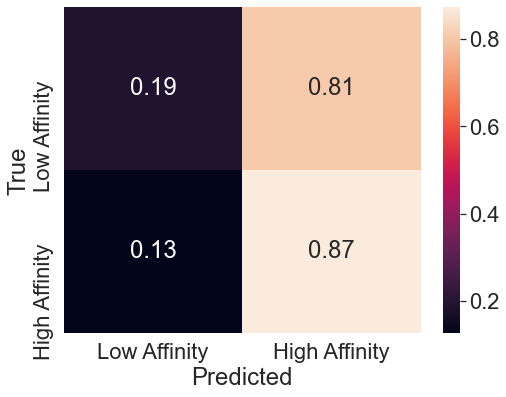

In [14]:
#plot the confusion matrix to visualize the classification results for data_Q493Y (H) and data_Q498K (L)
predictions = model.predict(test2B_images) 
y_pred = np.argmax(predictions, axis=1)
cm = tf.math.confusion_matrix(test2B_labels, y_pred)
cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]
plt.figure(figsize=(8, 6))
sns.set(font_scale=2)
sns.heatmap(
    cm, annot=True,
    xticklabels=class_names,
    yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

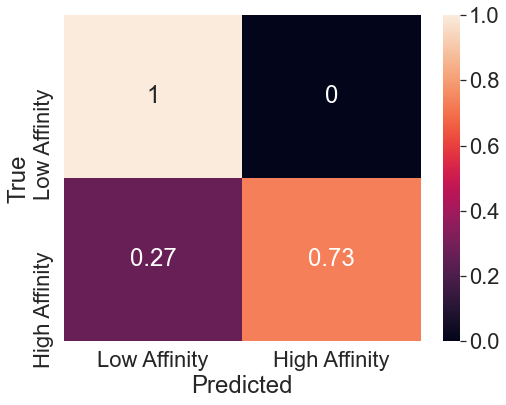

In [15]:
#plot the confusion matrix to visualize the classification results for data_E484K (H) data_Q493N (L)
predictions = model.predict(test2C_images) 
y_pred = np.argmax(predictions, axis=1)
cm = tf.math.confusion_matrix(test2C_labels, y_pred)
cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]
plt.figure(figsize=(8, 6))
sns.set(font_scale=2)
sns.heatmap(
    cm, annot=True,
    xticklabels=class_names,
    yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [16]:
# n=3
# print ('\nClass propbabilities for test image 0')
# print (predictions[n])
# print ('\nPrdicted class for test image 0:', np.argmax(predictions[n]))
# print ('Actual classification for test image 0:', test2A_labels[n])